In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
with open('classification_dataset/labels.txt') as f:
    labels = f.read().splitlines()
with open('classification_dataset/passages.txt') as f:
    passages = f.read().splitlines()

### Traditional methods

In [3]:
def clean_document(strs):
    strs = strs.replace('\\n', '').replace('\\r', '') # newline
    strs = re.sub('[^a-zA-Z]', ' ', strs) # punctuation
    strs = ' '.join(re.split('\s+', strs)) # duplicate whitespace
    strs = strs.lower().strip() # lowercase
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(strs)
    lemmatizer = WordNetLemmatizer()
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words]
    
    return ' '.join(filtered)

def num_years(sentence):
    strs = sentence.split(' ')
    count = 0
    for s in strs:
        match = re.match(r'.*([1-2][0-9]{3})', s)
        if match is not None:
            count += 1
    
    return count

In [4]:
df = pd.DataFrame()
df['label'] = labels
df['passage'] = passages
df['cleaned_text'] = df['passage'].apply(lambda x: clean_document(x))
df['num_years'] = df['passage'].apply(lambda x: num_years(x))
df.head()

,label,passage,cleaned_text,num_years
0,academics,As a liberal arts and sciences college nestled...,liberal art science college nestled within wor...,0
1,academics,Harvard College's academic opportunities expos...,harvard college academic opportunity expose wo...,0
2,academics,Research is the key that unlocks new knowledge...,research key unlocks new knowledge harvard put...,0
3,academics,The Academic Resource Center (ARC) at Harvard ...,academic resource center arc harvard universit...,0
4,academics,"We offer more than 3,700 courses in 50 undergr...",offer course undergraduate field study call co...,0


In [5]:
df['label'].unique()

array(['academics', 'student life', 'campus', 'history'], dtype=object)

label
academics       68
campus          51
history         52
student life    70
Name: cleaned_text, dtype: int64


<Axes: xlabel='label'>

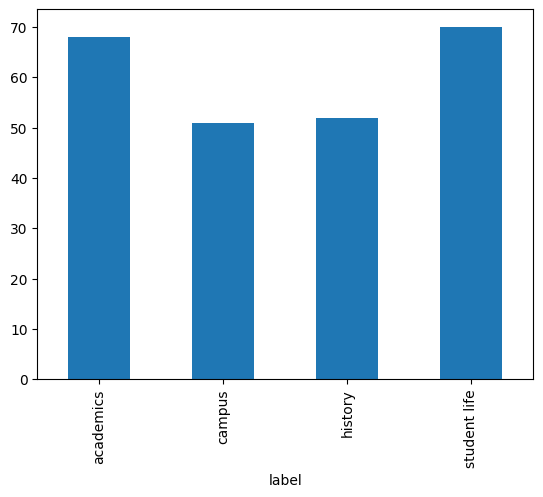

In [6]:
print(df.groupby('label').cleaned_text.count())
df.groupby('label').cleaned_text.count().plot.bar()

In [7]:
X = df[['cleaned_text', 'num_years']]
y = df['label']

column_transformer = ColumnTransformer([
    ('tfidf', TfidfVectorizer(), 'cleaned_text')
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [8]:
rfc = Pipeline([('preprocess', column_transformer),
                ('rfc', RandomForestClassifier(n_estimators=100, random_state=0))])

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(f'accuracy: {accuracy_score(y_pred, y_test)}')
print(classification_report(y_test, y_pred))

accuracy: 0.925
              precision    recall  f1-score   support

   academics       0.88      1.00      0.94        23
      campus       1.00      0.82      0.90        17
     history       1.00      0.82      0.90        17
student life       0.88      1.00      0.94        23

    accuracy                           0.93        80
   macro avg       0.94      0.91      0.92        80
weighted avg       0.93      0.93      0.92        80



In [9]:
# SVM with sgd
sgd = Pipeline([('preprocess', column_transformer),
                ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, tol=None))])

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print(f'accuracy: {accuracy_score(y_pred, y_test)}')
print(classification_report(y_test, y_pred))

accuracy: 1.0
              precision    recall  f1-score   support

   academics       1.00      1.00      1.00        23
      campus       1.00      1.00      1.00        17
     history       1.00      1.00      1.00        17
student life       1.00      1.00      1.00        23

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [10]:
log_reg = Pipeline([('preprocess', column_transformer),
                ('clf', LogisticRegression(C=1e5))])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(f'accuracy: {accuracy_score(y_pred, y_test)}')
print(classification_report(y_test, y_pred))

accuracy: 1.0
              precision    recall  f1-score   support

   academics       1.00      1.00      1.00        23
      campus       1.00      1.00      1.00        17
     history       1.00      1.00      1.00        17
student life       1.00      1.00      1.00        23

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



### LLM

In [11]:
from transformers import AutoTokenizer, pipeline
import torch

In [12]:
model = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
def prompt_llama2(prompt):
    prompt_template=f'''[INST] <<SYS>>
    You are a helpful, respectful and honest assistant.
    <</SYS>> {prompt} [/INST]'''
    
    sequences = pipeline(
        prompt_template,
        do_sample=True,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        #max_length=2048,
        temperature=1, # same every time
        top_p=0.95,
        top_k=40,
        repetition_penalty=1.1,
    )
    result = sequences[0]['generated_text']
    return result.split('[/INST]')[1].strip()

In [14]:
categories = ['academics', 'campus', 'history', 'student life']

prompt = f"""Here is the passage: {passages[8]}

Which of these categories is the passage related to: {categories[0]}, {categories[1]}, {categories[2]}, or {categories[3]}?
No preamble, get right to the answer. Output one choice and one word only. For example,

Input: Here is a passage...
Output: 'category'
"""
print(prompt)

Here is the passage: Our three main campuses—in Cambridge, Allston, and Boston—are a home to students and faculty, a hub of research and innovation, and a destination for visitors from all over the world.

Which of these categories is the passage related to: academics, campus, history, or student life?
No preamble, get right to the answer. Output one choice and one word only. For example,

Input: Here is a passage...
Output: 'category'



In [15]:
%%time
out = prompt_llama2(prompt)
print(out)

Sure thing! Based on the content of the provided passage, the category is...

Campus
CPU times: user 1.8 s, sys: 646 ms, total: 2.45 s
Wall time: 7.95 s


In [16]:
%%time
categories = ['academics', 'campus', 'history', 'student life']
pred = []
outputs = []
for i, (label, passage) in enumerate(zip(labels, passages)):
    prompt = f"""Here is the passage: {passage}

    Which of these categories is the passage related to: {categories[0]}, {categories[1]}, {categories[2]}, or {categories[3]}?
    No preamble, get right to the answer. Output one choice and one word only. For example,
    
    Input: Here is a passage...
    Output: 'category'
    """
    output = prompt_llama2(prompt)
    outputs.append(output)

    if 'academics' in output.lower():
        pred.append('academics')
    elif 'campus' in output.lower():
        pred.append('campus')
    elif 'history' in output.lower():
        pred.append('history')
    elif 'student life' in output.lower():
        pred.append('student life')
    else:
        pred.append('other')
        
    if i % 25 == 0:
        print(f'{i} done')

0 done


/home/ericzc2/miniconda3/envs/llm/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


25 done
50 done
75 done
100 done
125 done
150 done
175 done
200 done
225 done
CPU times: user 3min 45s, sys: 56.2 s, total: 4min 41s
Wall time: 4min 42s


In [17]:
print(f'accuracy: {accuracy_score(pred, labels)}')
print(classification_report(labels, pred))

accuracy: 0.8796680497925311
              precision    recall  f1-score   support

   academics       0.94      0.88      0.91        68
      campus       0.94      0.67      0.78        51
     history       0.77      0.98      0.86        52
student life       0.89      0.96      0.92        70

    accuracy                           0.88       241
   macro avg       0.89      0.87      0.87       241
weighted avg       0.89      0.88      0.88       241



In [18]:
for i, (l, p, o) in enumerate(zip(labels, pred, outputs)):
    if l != p:
        print(f'Index: {i}, label: {l}, pred: {p}')
        #print(o)
        print('-'*50)

Index: 0, label: academics, pred: student life
--------------------------------------------------
Index: 19, label: campus, pred: history
--------------------------------------------------
Index: 52, label: student life, pred: academics
--------------------------------------------------
Index: 53, label: student life, pred: campus
--------------------------------------------------
Index: 60, label: campus, pred: student life
--------------------------------------------------
Index: 70, label: campus, pred: history
--------------------------------------------------
Index: 71, label: campus, pred: history
--------------------------------------------------
Index: 72, label: campus, pred: history
--------------------------------------------------
Index: 86, label: student life, pred: campus
--------------------------------------------------
Index: 90, label: campus, pred: academics
--------------------------------------------------
Index: 107, label: campus, pred: student life
------------